In [1]:
from cleanlab import Datalab
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
from lib.MLP import BinaryTfidfMLPClassifier
from sklearn.model_selection import StratifiedKFold
from cleanlab.filter import find_label_issues
from sklearn.model_selection import StratifiedKFold
import numpy as np
from cleanlab.classification import CleanLearning

## Cleanlab
### Datalab Data Valuation
Cleanlab’s Shapely scores are transformed to lie between 0 and 1 such that: a score below 0.5 indicates a negative contribution to the model’s training performance, while a score above 0.5 indicates a positive contribution.

In [2]:
df_orig = pl.read_csv("../data/labeled/19_06/to_classify.csv").to_pandas()

label_col = "label"

true_labels = df_orig[label_col].to_list()

vectorizer = TfidfVectorizer()

# Transform the text data into a feature matrix
X_vectorized = vectorizer.fit_transform(df_orig['description_title_cats_compact'])

# Convert the sparse matrix to a dense matrix
X = X_vectorized.toarray()

In [3]:
lab = Datalab(data=df_orig, label_name=label_col, task="classification")

# Perform data valuation
lab.find_issues(features=X, issue_types={"data_valuation": {}})

# Collect the identified issues
data_valuation_issues = lab.get_issues("data_valuation")

Finding data_valuation issues ...

Audit complete. 55 issues found in the dataset.


In [4]:
mask = data_valuation_issues["data_valuation_score"] < 0.5
original_indices = data_valuation_issues[mask].index.tolist()

# Add data valuation score to original df
df_orig["data_valuation_score"] = data_valuation_issues["data_valuation_score"]

# Then filter
df_orig.loc[original_indices].sort_values(by="data_valuation_score")[["data_valuation_score",label_col,"description_title_cats_compact", "id_hash"]].iloc[:10]

,data_valuation_score,label,description_title_cats_compact,id_hash
120,0.497386,1,Förderung der selbstbestimmten Teilhabe von Me...,977e06d07074d61f892107592c378944
72,0.497549,1,Förderung von Forschungsvorhaben „Plattform Pr...,892750f7bab363532b99225c7886cd11
254,0.497712,1,Integrationsprojekte für Menschen mit Migratio...,6b4d125864be5f08e7819b80af8b5029
53,0.498039,1,ESF-Bundesprogramm – „rückenwind3 für Vielfalt...,83d023d6f250ed596d6dbc0aa3ce7ec7
7,0.498039,1,"Förderung von Projekten zur Inklusion, Partizi...",eda305464ae068152d4c084989b6a2ff
8,0.498366,1,Hamburger Partizipationsfonds (Förderbereich: ...,787895b92b2a20631d7053bb2aa7e2c4
121,0.498693,1,"Bürgerinnen und Bürger, Gleichstellung, Rechte...",7b228e2288ba3580d0aaac6df450b7f2
59,0.498693,1,Förderung von Kleinprojekten (Förderbereich: A...,122a5f6220d57c8614c593ea50188d31
128,0.498693,1,Umsetzung inklusiver Maßnahmen (RL Inklusion) ...,d72dc9bfe82d80f2fcb13cd6eafc39bc
235,0.498856,1,Förderung der Migrationsberatung in Niedersach...,2e9c664847c7be79bdd14975da44163e


In [5]:
data_val_hashes = df_orig.loc[original_indices]["id_hash"].to_list()

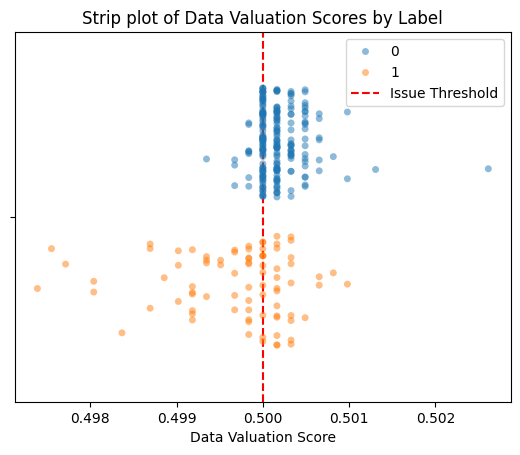

In [6]:
plot_data = (
    data_valuation_issues
    # Optionally, add a 'given_label' column to distinguish between labels in the histogram
    .join(pd.DataFrame({"given_label": df_orig[label_col]}))
)

# Plot strip plots of data valuation scores for each label
sns.stripplot(
    data=plot_data,
    x="data_valuation_score",
    hue="given_label",  # Comment out if no labels should be used in the visualization
    dodge=True,
    jitter=0.3,
    alpha=0.5,
)

plt.axvline(lab.info["data_valuation"]["threshold"], color="red", linestyle="--", label="Issue Threshold")

plt.title("Strip plot of Data Valuation Scores by Label")
plt.xlabel("Data Valuation Score")
plt.legend()
plt.show()

### Identify labeling issues with existing classifier

In [7]:
classifier = BinaryTfidfMLPClassifier.from_json('../models/optuna_tf_idf_mlp_params.json')
cl = CleanLearning(classifier, cv_n_folds=5)

skf = StratifiedKFold(n_splits=5)

texts = df_orig["description_title_cats_compact"].to_list()
true_labels = df_orig[label_col].to_list()

texts_array = np.array(texts)
labels_array = np.array(true_labels)

label_issues = cl.find_label_issues(
    texts_array,
    labels_array)

label_issues.head()

,is_label_issue,label_quality,given_label,predicted_label
0,False,0.993413,1,1
1,False,0.999999,1,1
2,False,1.000000,0,0
3,False,1.000000,0,0
4,True,0.000083,0,1


In [8]:
identified_issues = label_issues[label_issues["is_label_issue"] == True]
print(
    f"cleanlab found {len(identified_issues)} potential label errors in the dataset.\n"
)

cleanlab found 53 potential label errors in the dataset.



In [9]:
pdf = pd.DataFrame(
    {
        "text": texts,
        "id_hash" : df_orig["id_hash"].to_list(),
        "quality": label_issues["label_quality"],
        "given_label": true_labels,
        "predicted_label": label_issues["predicted_label"],
    },
).sort_values(by="quality", ascending=True).iloc[:20]

print(pdf.to_string(
    max_colwidth=100,
    max_rows=None,
    max_cols=None,
    show_dimensions=True
))


                                                                                                    text                           id_hash       quality  given_label  predicted_label
42   Deutschkenntnisse und Sprachmittlung bei Geflüchteten und anderen Menschen mit Migrationshinterg...  cf0977d6f26f94db220e54baffb6152f  0.000000e+00            0                1
72   Förderung von Forschungsvorhaben „Plattform Privatheit – IT-Sicherheit schützt Privatheit und st...  892750f7bab363532b99225c7886cd11  1.019710e-11            1                0
110  Europäischer Sozialfonds Plus (ESF+) in Hamburg (Förderbereich: Aus- & Weiterbildung, Arbeit, Fr...  468c16e23de167c7e5b7d848c63efa50  2.384186e-07            0                1
26   Beratungsstellen im Bereich Gewalt gegen Kinder und Jugendliche (Förderbereich: Gesundheit & Soz...  367aa96cf1c78c8decf306c03f2f0ba1  4.768372e-07            0                1
209  Solidarisches Zusammenleben der Generationen (Förderbereich: Gesundheit & Sozial

In [10]:
pl.from_pandas(df_orig).filter(pl.col("id_hash").str.contains("67e0acac0b9837a91570ea83ea5b06c3"))["description_md"].item()

'### Kurztext\n\nWenn Sie innovative Projektideen zum Einsatz von Open Data in ländlichen Kommunen umsetzen möchten, können Sie unter bestimmten Voraussetzungen einen Zuschuss erhalten.\n\n### Volltext\n\nDas Bundesministerium für Ernährung und Landwirtschaft (BMEL) setzt im BULEplus mit "Land.OpenData - Ideenwettbewerb" eine Fördermaßnahme um, welche die Bereitstellung und Verwendung von Open Data in ländlichen Räumen unterstützt.\n\nSie erhalten die Förderung für vorbereitende Maßnahmen zu den folgenden Themengebieten:\n\n* Wirtschaft\n* Demokratische Beteiligung und Ehrenamt\n* Dorfentwicklung\n* Tourismus, Freizeit und Kultur\n* Resilienz und digitale Transformation\n* Energiewende\n* Klimaschutz\n* Bürokratieabbau\n\nSie erhalten die Förderung als Zuschuss für einen Förderzeitraum von maximal 12 Monaten.\n\nDie Höhe des Zuschusses beträgt maximal 80 Prozent der zuwendungsfähigen Gesamtausgaben, maximal 50.000 EUR je Zuwendungsempfängerin oder Zuwendungsempfänger.\n\nDas Antragsver

In [11]:
pdf = pd.DataFrame(
    {
        "is_label_issue": label_issues["is_label_issue"],
        "id_hash" : df_orig["id_hash"].to_list()
    },
)
label_issue_id_hashes = pdf[pdf["is_label_issue"] == True]["id_hash"].to_list()

### Combining metrics

In [12]:
# get intersection of data_val_hashes and label_issue_id_hashes
intersection = set(data_val_hashes).intersection(set(label_issue_id_hashes))
print(f"Intersection: {len(intersection)}")
# get union
union = set(data_val_hashes).union(set(label_issue_id_hashes))
print(f"Union: {len(union)}")
print(f"Data val hashes: {len(data_val_hashes)}")
print(f"Label issue id hashes: {len(label_issue_id_hashes)}")
                         

Intersection: 16
Union: 92
Data val hashes: 55
Label issue id hashes: 53


In [13]:
cdf = pl.from_pandas(df_orig).with_columns([
    pl.Series("data_valuation_score", data_valuation_issues["data_valuation_score"]),
    pl.Series("label_quality", label_issues["label_quality"]),
    pl.Series("is_label_issue", label_issues["is_label_issue"]),
    pl.Series("predicted_label", label_issues["predicted_label"])
])
cdf = cdf.with_columns([
    (pl.col("data_valuation_score") < 0.5).alias("is_detrimental"),
    (pl.col("predicted_label") != pl.col(label_col)).alias("label_mismatch")
])
# Create polars df with union hashes
cdf = cdf.filter(pl.col("id_hash").is_in(union))["id_hash", "url", "title", "description_html", "description_title_cats_compact", "data_valuation_score", "label_quality", "is_detrimental","is_label_issue", "predicted_label",label_col,"label_mismatch"]


In [14]:
# cdf.write_csv("../data/labeled/19_06/to_correct.csv")